<a href="https://colab.research.google.com/github/Arif111866/Deep-Learning-AI/blob/main/Assignment_8/Unet_Segmentation_8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Training and Evaluating U-Net for Semantic Segmentatio

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("santhoshkumarv/dog-segmentation-dataset")

print("Path to dataset files:", path)

100%|██████████| 5.01M/5.01M [00:01<00:00, 4.01MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/santhoshkumarv/dog-segmentation-dataset/versions/1


In [2]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt
base_dir = '/root/.cache/kagglehub/datasets/santhoshkumarv/dog-segmentation-dataset/versions/1'
dataset_dir = os.path.join(base_dir, 'Dog Segmentation')
images = os.path.join(dataset_dir, 'Images')
masks = os.path.join(dataset_dir, 'Labels')
IMG_SIZE = (224, 224)


In [15]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import random
import os
import matplotlib.pyplot as plt

# Set the seed for reproducibility
def set_seeds(seed_value=42):
    random.seed(seed_value)
    np.random.seed(seed_value)
    tf.random.set_seed(seed_value)
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

# Data Loading and Preprocessing
def load_and_preprocess_data(image_dir, mask_dir, img_size=(128, 128)):
    images = []
    masks = []
    filenames = []

    for img_name in os.listdir(image_dir):
        img_path = os.path.join(image_dir, img_name)
        mask_path = os.path.join(mask_dir, f"annotated_{img_name}")

        if os.path.exists(mask_path):
            # Read and resize image
            img = cv2.imread(img_path)
            img = cv2.resize(img, img_size)
            img = img / 255.0  # Normalize

            # Read and resize mask
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            mask = cv2.resize(mask, img_size)
            mask = mask / 255.0  # Normalize
            mask = np.expand_dims(mask, axis=-1)

            images.append(img)
            masks.append(mask)
            filenames.append(img_name)

    return np.array(images), np.array(masks), filenames

# Standard U-Net Model Definition
def build_unet(input_shape=(128, 128, 3)):
    inputs = layers.Input(shape=input_shape)

    # Contracting Path (Encoder)
    c1 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(inputs)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(p1)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # Bridge
    c3 = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(p2)

    # Expansive Path (Decoder)
    u4 = layers.Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c3)
    u4 = layers.concatenate([u4, c2])
    c4 = layers.Conv2D(16, (3, 3), activation='relu', padding='same')(u4)

    u5 = layers.Conv2DTranspose(8, (2, 2), strides=(2, 2), padding='same')(c4)
    u5 = layers.concatenate([u5, c1])
    c5 = layers.Conv2D(8, (3, 3), activation='relu', padding='same')(u5)

    outputs = layers.Conv2D(1, (1, 1), activation='sigmoid')(c5)

    model = Model(inputs=inputs, outputs=outputs)
    return model

# Training Function
def train_model(model, X_train, y_train, X_val, y_val, batch_size=8, epochs=20):
    model.compile(
        optimizer=Adam(learning_rate=0.005),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    history = model.fit(
        X_train, y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_data=(X_val, y_val),
        callbacks=[
            tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(factor=0.2, patience=3)
        ]
    )
    return history

# Set the seed for reproducibility
set_seeds(seed_value=42)

base_dir = '/root/.cache/kagglehub/datasets/santhoshkumarv/dog-segmentation-dataset/versions/1/Dog Segmentation'
image_dir = os.path.join(base_dir, 'Images')
mask_dir = os.path.join(base_dir, 'Labels')

# Load and preprocess data
images, masks, filenames = load_and_preprocess_data(image_dir, mask_dir)

# Reserve 10 images for testing
test_size = 3
test_indices = [1,8,9]

test_images = images[test_indices]
test_masks = masks[test_indices]
test_filenames = [filenames[i] for i in test_indices]

# Remaining for training
train_indices = list(set(range(len(images))) - set(test_indices))
train_images = images[train_indices]
train_masks = masks[train_indices]

with tf.device('/GPU:0'):  # Or '/CPU:0' to force CPU
    model = build_unet(input_shape=(128, 128, 3))

# Train model
history = train_model(model, train_images, train_masks, test_images, test_masks)



Epoch 1/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 7s 86ms/step - accuracy: 0.5624 - loss: 0.6833 - val_accuracy: 0.6132 - val_loss: 0.6571 - learning_rate: 0.0050
Epoch 2/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5791 - loss: 0.6729 - val_accuracy: 0.6132 - val_loss: 0.6331 - learning_rate: 0.0050
Epoch 3/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.5836 - loss: 0.6492 - val_accuracy: 0.5849 - val_loss: 0.5773 - learning_rate: 0.0050
Epoch 4/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6037 - loss: 0.6369 - val_accuracy: 0.6199 - val_loss: 0.6073 - learning_rate: 0.0050
Epoch 5/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.5816 - loss: 0.6242 - val_accuracy: 0.6741 - val_loss: 0.5839 - learning_rate: 0.0050
Epoch 6/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6241 - loss: 0.6229 - val_accuracy: 0.5540 - val_loss: 0.5498 - learning_rate: 0.0050
Epoch 7/20
23/23 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.6273 - loss: 0.6096 - val_accu

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


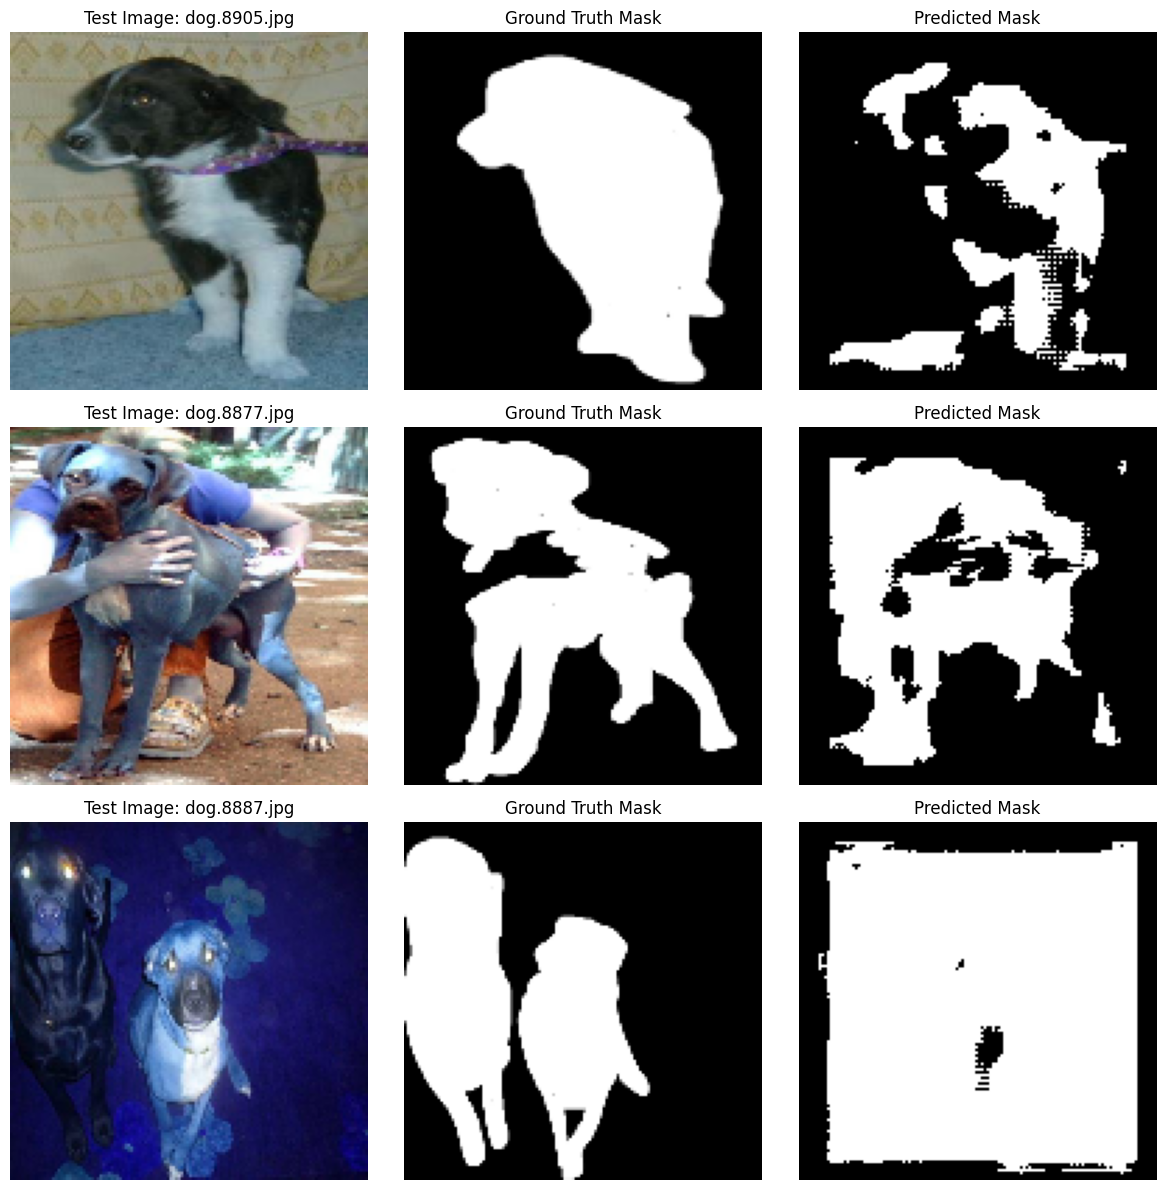

In [17]:
# Save the model
model.save('dog_segmentation_model.h5')
predicted_masks = model.predict(test_images)
predicted_masks = (predicted_masks > 0.5).astype(np.uint8)  # Threshold predictions
fig, axes = plt.subplots(test_size, 3, figsize=(12, 12))
for i, (img, true_mask, pred_mask, fname) in enumerate(zip(test_images, test_masks, predicted_masks, test_filenames)):
    # Display test image
    axes[i, 0].imshow(img)
    axes[i, 0].set_title(f"Test Image: {fname}")
    axes[i, 0].axis('off')

    # Display ground truth mask
    axes[i, 1].imshow(true_mask.squeeze(), cmap='gray')
    axes[i, 1].set_title("Ground Truth Mask")
    axes[i, 1].axis('off')

    # Display predicted mask
    axes[i, 2].imshow(pred_mask.squeeze(), cmap='gray')
    axes[i, 2].set_title("Predicted Mask")
    axes[i, 2].axis('off')

plt.tight_layout()
plt.show()